In [0]:
!pip install tf-nightly

In [64]:
import tensorflow as tf
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

print("Tensorflow Version: {}".format(tf.__version__))
print("Eager Mode: {}".format(tf.executing_eagerly()))
print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

Tensorflow Version: 2.2.0-dev20200115
Eager Mode: True
GPU is available


# Tensors

A Tensor is a multi-dimensional array and is similar with Numpy.Array. The differences between them are that a Tensor is the abstract concept in the computation graph. That is `tf.Tensor` can be operated or reside in the accelerator memtory and is immutable. A Tensor in Tensorflow has basically a data type and a shape.

Begin with Tensorflow 2.x, the eager mode is active be default. This makes more interactive and lots of operations would be easier converted to native Python runtime.

In [2]:
print(tf.add(1,2))
print(tf.add([1,2], [3,4]))

tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor([4 6], shape=(2,), dtype=int32)


In [3]:
print(tf.square(5))
print(tf.reduce_sum([1,2,3]))

tf.Tensor(25, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)


Operator overloading is also supported.

In [4]:
print(tf.square(2) + tf.square(3))

tf.Tensor(13, shape=(), dtype=int32)


In [5]:
x = tf.matmul([[1]], [[1, 2]]) # (1x1) * (1x2) = (1x2)
print(x)
print(x.shape)
print(x.dtype)

tf.Tensor([[1 2]], shape=(1, 2), dtype=int32)
(1, 2)
<dtype: 'int32'>


## Numpy Compatibility

Converting between a Tensorflow tensor and a Numpy array is easy.

* You can convert a Numpy array to a TF Tensor via the Tensorflow operations.
* You can convert a TF Tensor to a Numpy array via the Numpy operations.

Overall, you can convert the TF tensor to a Numpy array by accessing the `.numpy()` method. This operation is straightforward because the Numpy array and the TF tensor share the same representation in the memory. However, if TF tensor is saved on the accelerator memory, the tensor would be copied to the host memory for the Numpy accessing.

In [6]:
ndarray = np.ones(shape=[3,3])
ndarray

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

Convert a Numpy array to a TF tensor via the Tensorflow operators.

In [7]:
tftensor = tf.multiply(ndarray, 9)
tftensor

<tf.Tensor: shape=(3, 3), dtype=float64, numpy=
array([[9., 9., 9.],
       [9., 9., 9.],
       [9., 9., 9.]])>

Convert a TF tensor to a Numpy array via the Numpy operators.

In [8]:
add_tensor = np.add(tftensor, 1)
add_tensor

array([[10., 10., 10.],
       [10., 10., 10.],
       [10., 10., 10.]])

Access TF tensor's method `.numpy()` to convert to a Numpy array.

In [9]:
tftensor.numpy()

array([[9., 9., 9.],
       [9., 9., 9.],
       [9., 9., 9.]])

# GPU acceleration

Many Tensorflow operations are accelerated by using GPUs. By default without assignment, Tensorflow automatically decides which operations use which GPU or CPU. Tensors produced by an operation are typically noted as which device is used.

In [10]:
x = tf.random.uniform([3,3])

print("GPU {} available".format("is" if tf.config.experimental.list_physical_devices("GPU") else "not"))

print("Is the tensor on GPU: {}".format(x.device.endswith("GPU:0")))

GPU is available
Is the tensor on GPU: True


## Device Names

The `Tensor.device` provides lots of details used for different purposes, like distributed computing, etc. The device name is encoded as `GPU:<N>` where `N` represents `N`-th device on the host.

In [11]:
x.device

'/job:localhost/replica:0/task:0/device:GPU:0'

## Explicit Device Placement

You can assign an operation to run on a specific device via the `tf.device` APIs.

In [12]:
import time

def time_matmul(x):
  start = time.time()
  for loop in range(10):
    _ = tf.matmul(x, x)
  result = time.time() - start
  print("10 loops: {:0.2f}ms".format(1000*result))

# Force execution on CPU
print("On CPU:")
with tf.device("CPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("CPU:0")
  time_matmul(x)

# Force execution on GPU
print("On GPU:")
with tf.device("GPU:0"):
  x = tf.random.uniform([1000, 1000])
  assert x.device.endswith("GPU:0")
  time_matmul(x)

On CPU:
10 loops: 344.01ms
On GPU:
10 loops: 1408.54ms


# Datasets

Tensorflow provides the `tf.data.Dataset` API to build a high performance and access multiple data sources for the training and evaluation periods.

## Create a Source Dataset

The simplest way to load the dataset in memory is `from_tensor_slices()` method.

In [0]:
ds_tensor = tf.data.Dataset.from_tensor_slices([1,2,3,4,5,6])

The following is the example to create a temp CSV file and read it via the `tf.data.Dataset.TextLineDataset` API.

In [0]:
import tempfile

In [15]:
filename = tempfile.mktemp()
print(filename)

/tmp/tmp6iwjtsqd


In [0]:
with open(filename, "w") as fout:
  fout.write("""Line 1
Line 2
Line 3""")

In [17]:
!cat {filename}

Line 1
Line 2
Line 3

In [0]:
ds_file = tf.data.TextLineDataset(filename)

## Apply Transformations

Add functions like `map`, `batch`, `shuffle` to apply transformations to the dataset.

In [0]:
batch_ds = ds_tensor.map(tf.square).repeat(1).shuffle(2).batch(2)

In [0]:
batch_file = ds_file.batch(2)

## Inspect the Dataset



You can iterate the whole dataset or use `take` method to fetch the data in the unit of the batch size.

In [21]:
print("Elements of numeric data:")
for x in batch_ds:
  print(x)

Elements of numeric data:
tf.Tensor([4 1], shape=(2,), dtype=int32)
tf.Tensor([16 25], shape=(2,), dtype=int32)
tf.Tensor([36  9], shape=(2,), dtype=int32)


In [22]:
for x in batch_ds.take(2):
  print(x)

tf.Tensor([4 9], shape=(2,), dtype=int32)
tf.Tensor([ 1 25], shape=(2,), dtype=int32)


In [23]:
print("Elements of text data:")
for l in batch_file:
  print(l)

Elements of text data:
tf.Tensor([b'Line 1' b'Line 2'], shape=(2,), dtype=string)
tf.Tensor([b'Line 3'], shape=(1,), dtype=string)


In [24]:
for l in batch_file.take(1):
  print(l)

tf.Tensor([b'Line 1' b'Line 2'], shape=(2,), dtype=string)


# Custom Layers

## Layer Basis

A simple way to create a layer via the `tf.keras` API.

In [0]:
layers = tf.keras.layers.Dense(10, input_shape=(None, 5))

Call the layer.

In [26]:
layers(tf.zeros(shape=(10, 5)))

<tf.Tensor: shape=(10, 10), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

You can inspect the variables via the `.variables` method and `.trainable_variables` method for inspecting trainable variables.

In [27]:
layers.variables

[<tf.Variable 'dense/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.4584881 ,  0.01805502, -0.37165573, -0.21535781,  0.57285434,
         -0.27604336,  0.6321897 , -0.02281457,  0.6196211 , -0.4145236 ],
        [ 0.12240791,  0.4380538 ,  0.18116534,  0.26556188, -0.15803757,
         -0.35721377,  0.10275269, -0.03956062,  0.52383393,  0.15887159],
        [-0.41319078, -0.5583639 ,  0.00621098, -0.43564326,  0.15470636,
         -0.5963448 , -0.5550505 ,  0.09220457, -0.5615406 ,  0.5009026 ],
        [ 0.24148172, -0.34796783,  0.61692876, -0.531708  ,  0.46945816,
         -0.5870345 , -0.5094363 ,  0.53511614,  0.33668923,  0.04552597],
        [-0.09274602, -0.5968839 ,  0.18672734, -0.4007858 , -0.517043  ,
          0.02930599, -0.5042389 , -0.03556031,  0.33124995,  0.55947226]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>]

In [28]:
layers.kernel, layers.bias

(<tf.Variable 'dense/kernel:0' shape=(5, 10) dtype=float32, numpy=
 array([[-0.4584881 ,  0.01805502, -0.37165573, -0.21535781,  0.57285434,
         -0.27604336,  0.6321897 , -0.02281457,  0.6196211 , -0.4145236 ],
        [ 0.12240791,  0.4380538 ,  0.18116534,  0.26556188, -0.15803757,
         -0.35721377,  0.10275269, -0.03956062,  0.52383393,  0.15887159],
        [-0.41319078, -0.5583639 ,  0.00621098, -0.43564326,  0.15470636,
         -0.5963448 , -0.5550505 ,  0.09220457, -0.5615406 ,  0.5009026 ],
        [ 0.24148172, -0.34796783,  0.61692876, -0.531708  ,  0.46945816,
         -0.5870345 , -0.5094363 ,  0.53511614,  0.33668923,  0.04552597],
        [-0.09274602, -0.5968839 ,  0.18672734, -0.4007858 , -0.517043  ,
          0.02930599, -0.5042389 , -0.03556031,  0.33124995,  0.55947226]],
       dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(10,) dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>)

## Custom Layers

The best way to implement your custom layer is extending from `tf.keras.Layer` class and to implement its `__init__`, `build` and `call` methods.


* method `__init__`: implement input-dependent initialization
* method `build` (optional): where you know the input shape and do the rest of the initialization
* method `call`: do the forward computation

You can move the job from the method `build` to `__init__`. However, such operations require an explicit input shape. Instead, you can keep this job back in `build` method for receiving the input shape of the input tensor.

In [0]:
class DenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(DenseLayer, self).__init__()
    self.num_outputs = num_outputs
  
  def build(self, input_shape):
    self.kernel = self.add_weight(
      "kernel", 
      shape=[int(input_shape[-1]), self.num_outputs])
    self.bias = self.add_weight(
      "bias", 
      shape=[int(input_shape[0]), self.num_outputs])
    
  def call(self, input):
    return tf.matmul(input, self.kernel) + self.bias

Create a customized layer.

In [0]:
dense = DenseLayer(10)

In [0]:
_ = dense(tf.zeros(shape=[10, 5]))

In [32]:
print([var.name for var in dense.trainable_variables])

['dense_layer/kernel:0', 'dense_layer/bias:0']


## Models: Composing Layers

The composing layer is an interesting thing that composes lots of existing layers. For example, each residual block in a ResNet is a composition of convolution layers, batch normalization, etc. **Layers can be nested inside other layers.**

The following is a ResNet block.

In [0]:
class ResnetIdentityBlock(tf.keras.Model):
  def __init__(self, kernel_size, filters):
    super(ResnetIdentityBlock, self).__init__()
    filters1, filters2, filters3 = filters

    self.conv2_1 = tf.keras.layers.Conv2D(filters=filters1, kernel_size=(1, 1), 
                                          strides=(1, 1), padding='same')
    self.bn2_1 = tf.keras.layers.BatchNormalization()

    self.conv2_2 = tf.keras.layers.Conv2D(filters=filters2, kernel_size=kernel_size, 
                                          strides=(1, 1), padding='same')
    self.bn2_2 = tf.keras.layers.BatchNormalization()

    self.conv2_3 = tf.keras.layers.Conv2D(filters=filters3, kernel_size=(1, 1),
                                          strides=(1, 1), padding='same')
    self.bn2_3 = tf.keras.layers.BatchNormalization()

  def call(self, input_tensor, training=False):
    x = self.conv2_1(input_tensor)
    x = self.bn2_1(x, training=training)
    x = tf.keras.activations.relu(x)

    x = self.conv2_2(x)
    x = self.bn2_2(x, training=training)
    x = tf.keras.activations.relu(x)

    x = self.conv2_3(x)
    x = self.bn2_3(x, training=training)
    x = tf.keras.activations.relu(x)

    x += input_tensor
    return tf.keras.activations.relu(x)

In [0]:
block = ResnetIdentityBlock((1,1), [1, 2, 3])

In [35]:
inputs = tf.zeros([1, 2, 3, 3])  # 1 (batch) x 2 (height) x 3 (width) x 3 (channel)
inputs.shape

TensorShape([1, 2, 3, 3])

In [36]:
outputs = block(inputs)
outputs

<tf.Tensor: shape=(1, 2, 3, 3), dtype=float32, numpy=
array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]]], dtype=float32)>

In [37]:
block.layers

In [38]:
block.summary()

Model: "resnet_identity_block"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  4         
_________________________________________________________________
batch_normalization (BatchNo multiple                  4         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  4         
_________________________________________________________________
batch_normalization_1 (Batch multiple                  8         
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  9         
_________________________________________________________________
batch_normalization_2 (Batch multiple                  12        
Total params: 41
Trainable params: 29
Non-trainable params: 12
________________________________________________

In [39]:
len(block.variables), block.variables

(18,
 [<tf.Variable 'resnet_identity_block/conv2d/kernel:0' shape=(1, 1, 3, 1) dtype=float32, numpy=
  array([[[[ 0.462605  ],
           [ 0.41850746],
           [-0.7979455 ]]]], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/conv2d/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/batch_normalization/gamma:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/batch_normalization/beta:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/batch_normalization/moving_mean:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/batch_normalization/moving_variance:0' shape=(1,) dtype=float32, numpy=array([1.], dtype=float32)>,
  <tf.Variable 'resnet_identity_block/conv2d_1/kernel:0' shape=(1, 1, 1, 2) dtype=float32, numpy=array([[[[ 0.69618666, -1.4031788 ]]]], dtype=float32)>,
  <tf.

# Automatic Differentiation and Gradient Tape

## Gradient Tapes

Tensorflow provides the `tf.GradientTape` API for automatic differentiation.

In [40]:
x = tf.ones(shape=(2, 2))
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [0]:
with tf.GradientTape() as tape:
  tape.watch(x)
  y = tf.reduce_sum(x)
  z = tf.multiply(y, y)

**Derivative of z with respect to the original input tensor x.**

$$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} = (2y)*4$$

In [0]:
dz_dx = tape.gradient(z, x)
for i in [0, 1]:
  for j in [0, 1]:
    assert dz_dx[i][j].numpy() == 8.0

By default, a GradientTape is released after the method `.gradient()` was called. If you want to do multiple gradient calculations, add the parameter `persistent=True` to the Grandientape.

$$z = y^2\ where\ y = x^2,\ z = x^4$$
$$\frac{dz}{dy} = 2y, \frac{dy}{dx} = 2x$$
$$\frac{dz}{dx} = \frac{dz}{dy} * \frac{dy}{dx} = 2y * 2x = 2(x^2) * 2x = 4x^3$$

In [0]:
x = tf.constant(3.0)

with tf.GradientTape(persistent=True) as tape:
  tape.watch(x)
  y = x * x
  z = y * y

dz_dx = tape.gradient(z, x)
dy_dx = tape.gradient(y, x)
del tape

assert dz_dx == 108.0 # 4*(3^3)
assert dy_dx == 6.0 # 2*3

## Recording Control Flow

In [0]:
def f(x, y):
  """x^y"""
  output = 1.0
  for i in range(y):
    if i > 1 and i < 5:
      # recording control flow
      # x only be multiply while i in [2, 3, 4]
      output = tf.multiply(output, x)
  return output

In [0]:
def grad(x, y):
  with tf.GradientTape() as tape:
    tape.watch(x)
    out = f(x, y)
  return tape.gradient(out, x)

In [0]:
x = tf.convert_to_tensor(2.0)

assert grad(x, 4) == 4.0 # x^2 => 2*x
assert grad(x, 5) == 12.0 # x^3 => 3x^2
assert grad(x, 6) == 12.0 # x^3 => 3x^2

## Higher-Order Gradients

if a gradient is computed in a GradientTape, it is also recorded.

$$y = x^3$$
$$\frac{dy}{dx} = 3x^2, \frac{d^2y}{d^2x} = 6x$$

In [47]:
x = tf.Variable(1.0)

with tf.GradientTape() as t:
  with tf.GradientTape() as t2:
    y = x * x * x
  
  dy_dx = t2.gradient(y, x)
dy2_dx2 = t.gradient(dy_dx, x)

print(dy_dx, dy2_dx2)

tf.Tensor(3.0, shape=(), dtype=float32) tf.Tensor(6.0, shape=(), dtype=float32)


# Variables

Tensors in Tensorflow are immutable stateless objects. However, ML models must have changing states and would be changed as the training progressed. To represent this behavior, you can rely on Python, a stateful programming language.

In [50]:
# numeric value is immutable
a = 1
print(id(a))

a = 2
print(id(a))

10914496
10914528


In [54]:
# list object is mutable
l = list([1,2,3])
print(id(l))
print(id(l[0]))

l[0] = 10
print(id(l))  # list object is mutable
print(id(l[0]))   # numeric value in list is immutable|

140565374319560
10914496
140565374319560
10914784


In [49]:
x = tf.zeros(shape=[10, 10])
x += 2  # x = x + 2, thid does not mutate the origin value of x in Python
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


In Tensorflow, `tf.Variable` provides a stateful operation and could be used to represent the weights. A `tf.Variable` objects store a value and implicitly read the stored value. In Tensorflow, lots of built-in operations, like `tf.assign_sub`, `tf.scatter_update`, could manipulate the value stored in the Tensorflow variables.

In [0]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0

v.assign(3.0)
assert v.numpy() == 3.0

v.assign(tf.square(v))
assert v.numpy() == 9.0

Computations using `tf.Variable` are automatically traced when computing gradients.

# Training

## Data Preprocesssing

First, let's synthesize the training data by adding random Gaussian (Normal) noise to the inputs.

In [0]:
TRUE_W = 3.0
TRUE_B = 2.0
NUM_EXAMPLES = 1000

In [59]:
inputs = tf.random.normal(shape=[NUM_EXAMPLES])
noise = tf.random.normal(shape=[NUM_EXAMPLES])
outputs = inputs * TRUE_W + TRUE_B + noise
outputs.shape

TensorShape([1000])

## Defining a Model

In [0]:
class Model(object):
  def __init__(self):
    # in practice, these initializations would be random values
    self.W = tf.Variable(5.0)
    self.b = tf.Variable(0.0)
  
  def __call__(self, x):
    return self.W * x + self.b
  
model = Model()

In [0]:
assert model(3) == 15.0

## Defining a Loss Function

A loss function measures how well the output of the model for a given input matches the target output. The training goal is to minimize the difference during training. This is a regression problem. Here, let's use L2 loss, a.k.a the least square error, as the loss function.

In [0]:
def loss(predicted_y, target_y):
  return tf.reduce_mean(tf.square(predicted_y - target_y))

## Inspect the Data

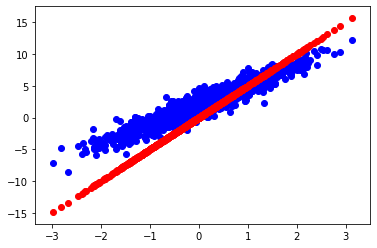

In [67]:
plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

In [68]:
print("Current Loss: {:1.6f}".format(loss(model(inputs), outputs)))

Current Loss: 8.298947


## Defining a Training Loop

With the ML model and dataset, train the model using `Gradient Descent` to update the model weights (weight `W` and bias `b`) to reduce the loss. In practice or for convenience, you can use lots of built-in optimizers in `tf.train.Optimizer`. However, here let's build the first optimizer to use `tf.GradientTape()` to automatically compute differentiation and use `tf.assign_sub` with `learning_rate` and `differentiation values` to update the weights .

In [0]:
def train(model, inputs, outputs, learning_rate):
  with tf.GradientTape() as tape:
    current_loss = loss(model(inputs), outputs)
  dW, db = tape.gradient(current_loss, [model.W, model.b])
  model.W.assign_sub(learning_rate * dW)
  model.b.assign_sub(learning_rate * db)

Epoch: 0, W: 5.00, b: 0.00, loss: 8.30
Epoch: 1, W: 4.63, b: 0.38, loss: 5.74
Epoch: 2, W: 4.33, b: 0.69, loss: 4.08
Epoch: 3, W: 4.09, b: 0.94, loss: 3.00
Epoch: 4, W: 3.89, b: 1.14, loss: 2.30
Epoch: 5, W: 3.74, b: 1.30, loss: 1.84
Epoch: 6, W: 3.61, b: 1.42, loss: 1.55
Epoch: 7, W: 3.50, b: 1.53, loss: 1.36
Epoch: 8, W: 3.42, b: 1.61, loss: 1.23
Epoch: 9, W: 3.35, b: 1.67, loss: 1.15
Epoch: 10, W: 3.30, b: 1.73, loss: 1.10
Epoch: 11, W: 3.25, b: 1.77, loss: 1.06
Epoch: 12, W: 3.22, b: 1.80, loss: 1.04
Epoch: 13, W: 3.19, b: 1.83, loss: 1.03
Epoch: 14, W: 3.16, b: 1.85, loss: 1.02
Epoch: 15, W: 3.14, b: 1.87, loss: 1.01
Epoch: 16, W: 3.13, b: 1.88, loss: 1.01
Epoch: 17, W: 3.12, b: 1.90, loss: 1.00
Epoch: 18, W: 3.10, b: 1.90, loss: 1.00
Epoch: 19, W: 3.10, b: 1.91, loss: 1.00
Epoch: 20, W: 3.09, b: 1.92, loss: 1.00
Epoch: 21, W: 3.08, b: 1.92, loss: 1.00
Epoch: 22, W: 3.08, b: 1.93, loss: 1.00
Epoch: 23, W: 3.08, b: 1.93, loss: 1.00
Epoch: 24, W: 3.07, b: 1.93, loss: 1.00
Epoch: 25,

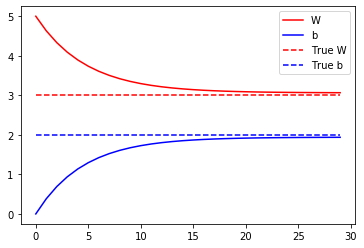

In [72]:
model = Model()

# historial records
Ws, bs = [], []
epochs = range(30)

# a training loop
for epoch in epochs:
  Ws.append(model.W.numpy())
  bs.append(model.b.numpy())
  current_loss = loss(model(inputs), outputs)

  train(model, inputs, outputs, learning_rate=1e-1)
  print("Epoch: {}, W: {:1.2f}, b: {:1.2f}, loss: {:1.2f}".format(
    epoch, Ws[-1], bs[-1], current_loss
  ))

# plot the result
plt.plot(epochs, Ws, 'r')
plt.plot(epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--')
plt.plot([TRUE_B] * len(epochs), 'b--')
plt.legend(['W', 'b', 'True W', 'True b'])
plt.show()